#  Прогнозирование котировок BTC

Целью проекта является прогнозиирование котировок BTC за следующие полчаса с помощью LSTM.

In [1]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import requests
import csv
import warnings
from keras.layers import Bidirectional
from keras.models import Sequential 
from keras.layers import Flatten, LSTM 
from keras.layers.core import Activation, Dropout, Dense 
from datetime import datetime, timedelta
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.sparse import coo_matrix, vstack
from phik.report import plot_correlation_matrix
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
warnings.filterwarnings('ignore')
sns.set()

## Подготовка данных

**Так как без регистрации разрешено скачивать только 500 точек, то посчитаем все в цикле, чтобы объединить в один dataframe с начала года по сей день (чтобы запускать без профиля API Binance )**

In [3]:
names = ['Date', 'Open', 'High', 
             'Low', 'Close', 'Volume', 
             'Close Time', 'Quote Asset Volume', 
             'Number of Trades', 'Taker Buy Base Asset Volume', 
             'Taker Buy Quote Asset Volume', 'Ignore']
df = pd.DataFrame(columns = names)
df = df.set_index('Date')
start = int(datetime(2023, 1, 1).timestamp() * 1000) #начало отсчета
finish = int(datetime.now().timestamp() * 1000) #считаем актуальную дату 
delta_time = 30 * 500 * 60 * 1000 #считаем временной скачок для цикла
n_loops = int((finish - start) / delta_time) #необходимое количество циклов 

In [4]:
# Скачаем данные с шагом в 30 минут
def download_df(data_frame, names, start,finish):
    """Загружаем данные и соединяем их с предыдущим датафреймом"""
    
    
    url = "https://api.binance.com/api/v3/klines"
    params = {
        "symbol": "BTCUSDT",
        "interval": "30m",
        "startTime": start,
        "endTime": finish
    }
    response = requests.get(url, params=params)
    data = response.json()
    df = pd.DataFrame(data,columns = names)
    df = df.set_index('Date')
    df = pd.concat([data_frame,df])
    return df, df.index[-1]


s = start
for _ in range(n_loops+1):
    df, s = download_df(df,names,s,finish)
    
df_btc = df.copy()
df_btc.index = pd.to_datetime(df.index,unit='ms')

**Полученный датасет. Конвертируем значения в тип int**

In [5]:
df_btc.to_csv('df_btc.csv')
df_btc.head()

,Open,High,Low,Close,Volume,Close Time,Quote Asset Volume,Number of Trades,Taker Buy Base Asset Volume,Taker Buy Quote Asset Volume,Ignore
Date,,,,,,,,,,,
2022-12-31 21:00:00,16568.19000000,16571.64000000,16557.46000000,16563.84000000,1742.00907000,1672522199999,28856438.61787240,52514,847.17069000,14033607.92208840,0
2022-12-31 21:30:00,16563.57000000,16568.34000000,16544.12000000,16548.28000000,1876.76482000,1672523999999,31071589.46206450,52551,899.24269000,14888288.29468400,0
2022-12-31 22:00:00,16548.28000000,16567.49000000,16506.36000000,16544.98000000,3107.43391000,1672525799999,51399450.83875720,72408,1490.38573000,24651909.00169010,0
2022-12-31 22:30:00,16544.78000000,16553.30000000,16470.00000000,16520.81000000,3587.70234000,1672527599999,59267476.81847780,81525,1629.57240000,26919618.76815690,0
2022-12-31 23:00:00,16520.28000000,16529.54000000,16487.74000000,16524.64000000,3065.44852000,1672529399999,50613149.78878560,91105,1507.54232000,24890769.80440910,0


In [6]:
df_btc = df_btc.drop(['Close Time','Ignore'],axis=1)
df_btc = df_btc.astype(float).astype(int)

## Анализ данных

In [7]:
df_btc.describe()

,Open,High,Low,Close,Volume,Quote Asset Volume,Number of Trades,Taker Buy Base Asset Volume,Taker Buy Quote Asset Volume
count,7092.000000,7092.000000,7092.000000,7092.000000,7092.000000,7.092000e+03,7.092000e+03,7092.000000,7.092000e+03
mean,24881.608009,24939.888043,24822.421743,24883.234772,4086.292583,9.553751e+07,1.017214e+05,2037.086999,4.764305e+07
std,3657.504602,3666.193084,3646.795904,3656.287042,4579.970020,1.065645e+08,9.829550e+04,2299.943458,5.359187e+07
min,16513.000000,16522.000000,16470.000000,16513.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
25%,22573.750000,22624.750000,22509.500000,22575.500000,852.750000,2.394706e+07,1.956475e+04,419.750000,1.179119e+07
50%,24851.000000,24945.000000,24776.000000,24854.500000,2887.000000,6.548497e+07,8.151100e+04,1442.500000,3.254542e+07
75%,27927.000000,27992.250000,27873.000000,27927.250000,5443.000000,1.238197e+08,1.520070e+05,2702.250000,6.163927e+07
max,30942.000000,31000.000000,30850.000000,30942.000000,59890.000000,1.520517e+09,1.036001e+06,31988.000000,8.119615e+08


**Мы видим растущий тренд. Деконуструируем, чтобы посмотреть сезонность, тренд и остаток**

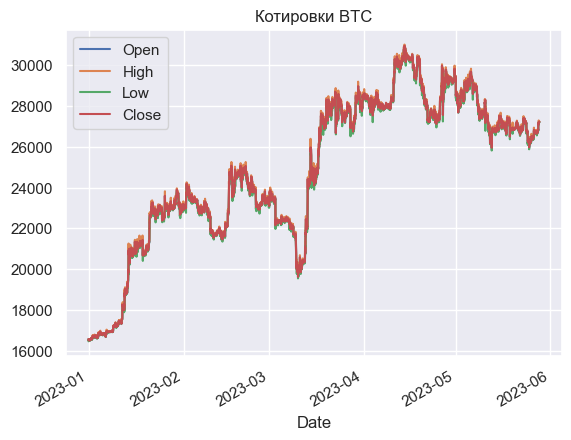

In [8]:
df_btc.plot(y=['Open','High','Low','Close'])
plt.title('Котировки BTC')
plt.show()

*Посмотрим за последние сутки*

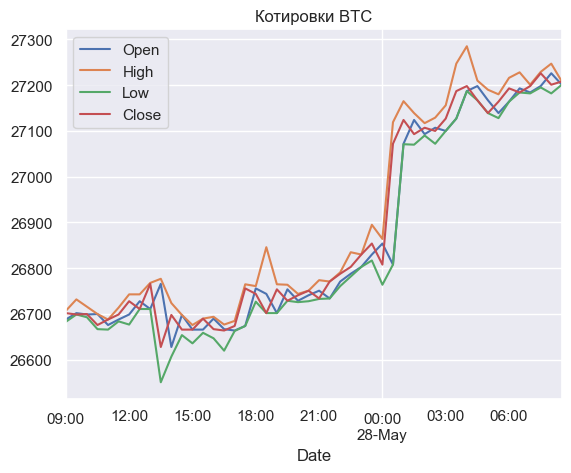

In [9]:
df_btc.iloc[-48:].plot(y=['Open','High','Low','Close'])
plt.title('Котировки BTC')
plt.show()

In [10]:
decompose = seasonal_decompose(df_btc['Close'], period=1*48)

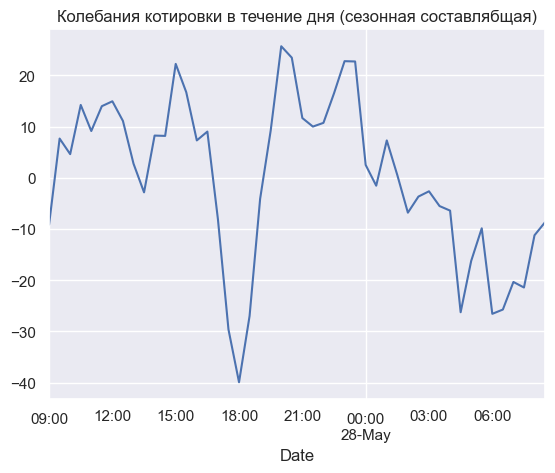

In [11]:
decompose.seasonal[-48:].plot()
plt.title('Колебания котировки в течение дня (сезонная составлябщая)')
plt.show()

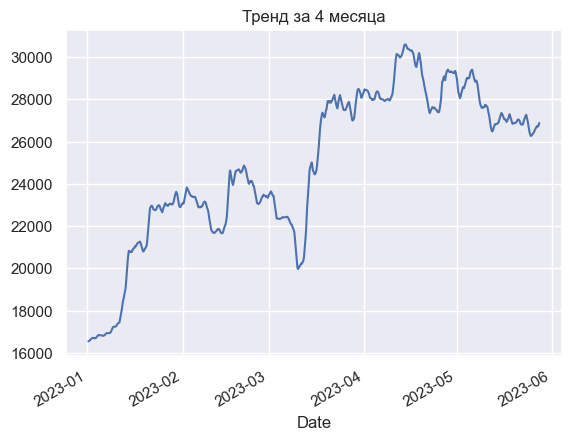

In [12]:
decompose.trend.plot()
plt.title('Тренд за 4 месяца')
plt.show()

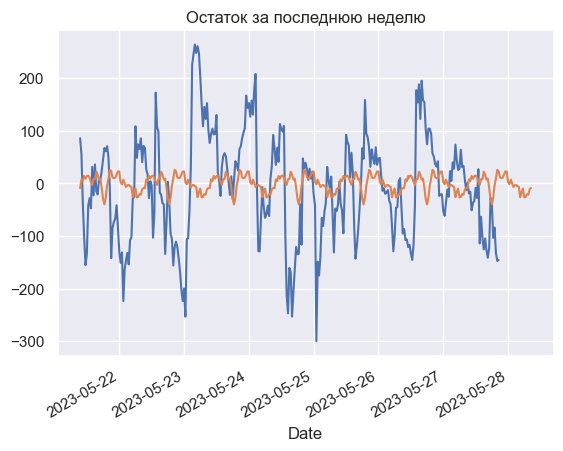

In [13]:
decompose.resid[-7*48:].plot()
decompose.seasonal[-7*48:].plot()
plt.title('Остаток за последнюю неделю')
plt.show()

**Остаток котировок значительно превышает значения колебаний, что говорит о том, что сезонности как таковой нет**

*Проверим стационнарность временного ряда. Применим  тест Дики-Фуллера. В данном случае гипотезы звучат следующим образом:*

- Нулевая гипотеза предполагает, что процесс нестационарный
- Альтернативная гипотеза соответственно говорит об обратном


In [14]:
adf_test = adfuller(df_btc['Close'])
print('p-value = ' + str(adf_test[1]))

p-value = 0.20672131205388683


*Нет сомнений, что ряд* **нестационнарен**

**Построим матрицу корреляций**

interval columns not set, guessing: ['Open', 'High', 'Low', 'Close', 'Volume', 'Quote Asset Volume', 'Number of Trades', 'Taker Buy Base Asset Volume', 'Taker Buy Quote Asset Volume']


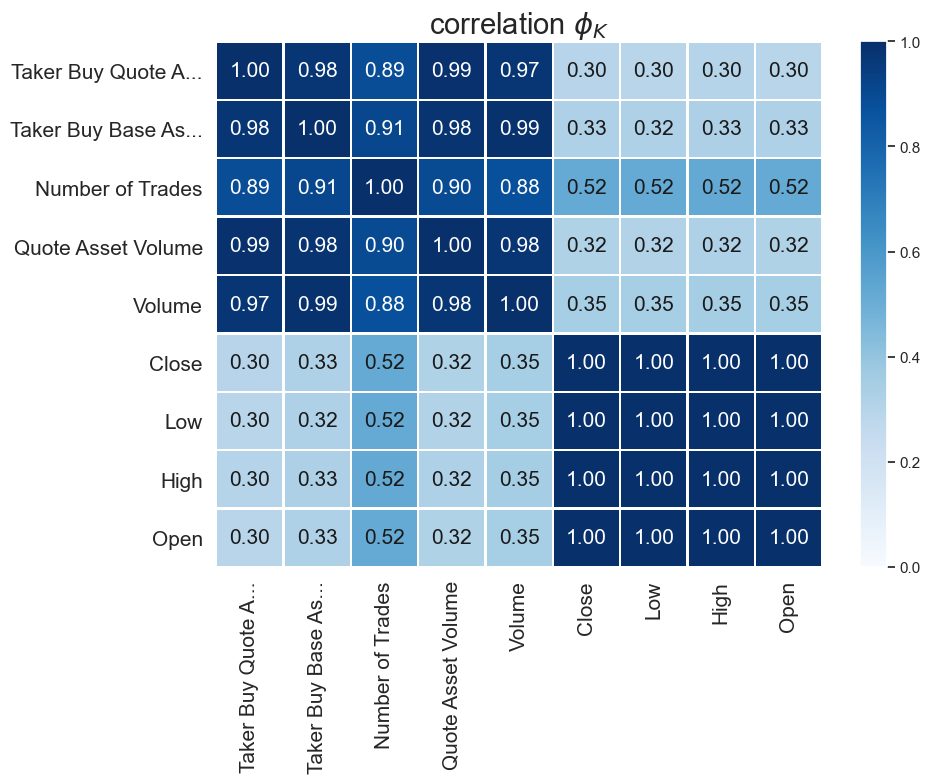

In [15]:
phik_overview = df_btc.phik_matrix()

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Blues", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(10, 8))
plt.tight_layout()

**Так как большинство признаков коррелирует между собой оставим только Close, Taker Buy Base Asset Volume и Number of Trades, чтобы избежать мультиколлинеарности**

## Обучение модели

**Чтобы оценивать результаты модели, создадим сначала простую линейную регрессию**

*Для столбца Clsoe посчитаем лаги с шагом 30 минут до 2 суток, а также сместим остальные два признака для избежания утечки данных*

In [16]:
btc = df_btc[['Close','Taker Buy Base Asset Volume','Number of Trades']]
for lag in range(2, 48):
    btc['lag_{}'.format(lag)] = btc['Close'].shift(lag)
btc['lag_TBBAV'] = btc['Taker Buy Base Asset Volume'].shift(2)
btc['lag_NT'] = btc['Number of Trades'].shift(2)
btc = btc.dropna()

In [17]:
target = btc['Close']
feature = btc.drop(['Close','Taker Buy Base Asset Volume','Number of Trades'],axis=1)

*Подготовим признаки и масштабируем их*

In [18]:
feature_train, feature_test, target_train, target_test = train_test_split(feature, target,shuffle=False,test_size=.3)
feature_valid, feature_test, target_valid, target_test = train_test_split(feature_test, target_test,shuffle=False,test_size=.5)
scale = MinMaxScaler()
scale.fit(feature_train)
feature_train = scale.transform(feature_train)
feature_valid = scale.transform(feature_valid)
feature_test  = scale.transform(feature_test)

*Чтобы посмотреть корректность будущей модели, посчитаем простую линейную регрессию*

RMSE =  159.59625799602605
MAE =  9.457972150855673


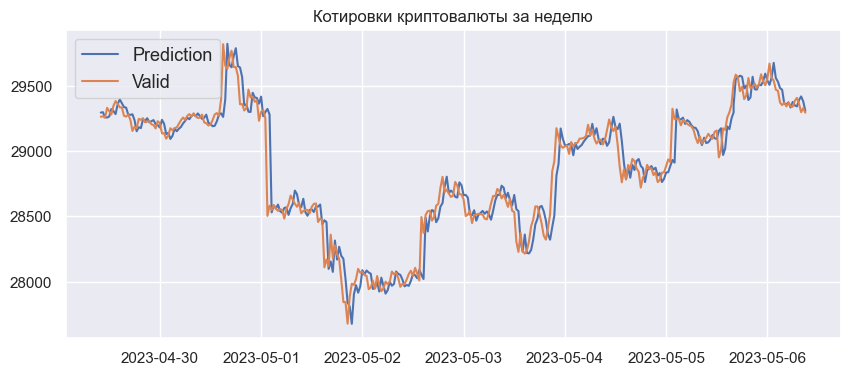

In [19]:
model_lr = LinearRegression()
model_lr.fit(feature_train,target_train)
predict_lr = pd.DataFrame(model_lr.predict(feature_valid),index=target_valid.index)
plt.figure(figsize=(10, 4))
plt.plot(predict_lr[-48*7:],label='Prediction')
plt.plot(target_valid[-48*7:],label='Valid')
plt.legend(loc="best", fontsize=13)
plt.title('Котировки криптовалюты за неделю')
print('RMSE = ',np.sqrt(mean_squared_error(target_valid,predict_lr)))
print('MAE = ',np.sqrt(mean_absolute_error(target_valid,predict_lr)))

**Вывод: видно, что линейная регрессия достаточно хорошо предсказала тренд (MAE = 11.5)**

Text(0.5, 1.0, 'Котировки криптовалюты c 13 по 28 марта')

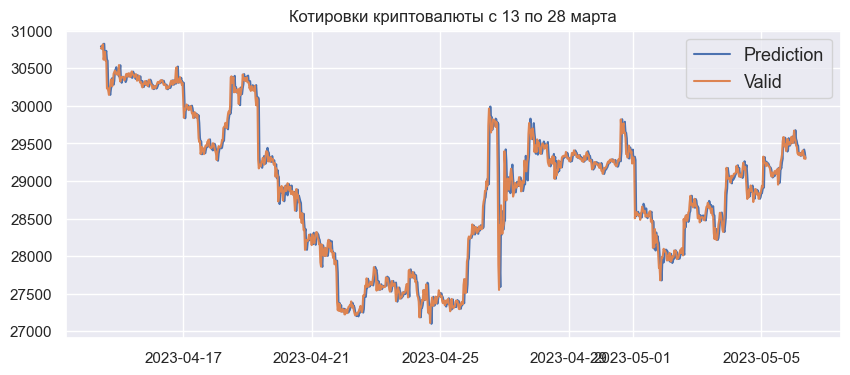

In [20]:
plt.figure(figsize=(10, 4))
plt.plot(predict_lr,label='Prediction')
plt.plot(target_valid,label='Valid')
plt.legend(loc="best", fontsize=13)
plt.title('Котировки криптовалюты c 13 по 28 марта')

**Для модели LSTM подготовим новые признаки. Чтобы модель считалась быстрее будем предсказывать временной ряд только по одному столбцу**

In [21]:
ts = df_btc['Close'].values

In [22]:
ts_train, ts_test = train_test_split(ts, shuffle=False,test_size=.3)
ts_valid, ts_test = train_test_split(ts_test, shuffle=False,test_size=.5)

*Код ниже подготавливает данные для применения в модели LSTM, так как нам необходимо предсказать следующий час, то количество шагов вывод равно 2 (так как шаг = 30 мин), учить будем с окном в 15 шагов*

In [23]:
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_steps_in, n_steps_out = 15, 2
# split into samples
X, y = split_sequence(ts_train, n_steps_in, n_steps_out)
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [24]:
model = Sequential()
model.add(LSTM(150, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(80, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')

In [25]:
model.fit(X, y, epochs = 200, batch_size = 32)

Epoch 1/200
155/155 [==============================] - 7s 22ms/step - loss: 13445735.0000
Epoch 2/200
155/155 [==============================] - 4s 23ms/step - loss: 198739.9844
Epoch 3/200
155/155 [==============================] - 4s 23ms/step - loss: 74009.7812
Epoch 4/200
155/155 [==============================] - 3s 22ms/step - loss: 75148.2656
Epoch 5/200
155/155 [==============================] - 3s 22ms/step - loss: 74407.6250
Epoch 6/200
155/155 [==============================] - 4s 23ms/step - loss: 75451.6875
Epoch 7/200
155/155 [==============================] - 4s 26ms/step - loss: 76939.7344
Epoch 8/200
155/155 [==============================] - 4s 26ms/step - loss: 75465.6562
Epoch 9/200
155/155 [==============================] - 4s 26ms/step - loss: 80952.8047
Epoch 10/200
155/155 [==============================] - 4s 24ms/step - loss: 77480.4766
Epoch 11/200
155/155 [==============================] - 4s 24ms/step - loss: 78303.6641
Epoch 12/200
155/155 [===============

155/155 [==============================] - 4s 28ms/step - loss: 89182.7812
Epoch 95/200
155/155 [==============================] - 5s 29ms/step - loss: 87823.0938
Epoch 96/200
155/155 [==============================] - 4s 28ms/step - loss: 88968.0078
Epoch 97/200
155/155 [==============================] - 4s 27ms/step - loss: 89092.8984
Epoch 98/200
155/155 [==============================] - 4s 29ms/step - loss: 88571.1797
Epoch 99/200
155/155 [==============================] - 5s 29ms/step - loss: 88653.7031
Epoch 100/200
155/155 [==============================] - 4s 27ms/step - loss: 90280.1094
Epoch 101/200
155/155 [==============================] - 4s 27ms/step - loss: 89440.9297
Epoch 102/200
155/155 [==============================] - 4s 29ms/step - loss: 88205.0469
Epoch 103/200
155/155 [==============================] - 4s 29ms/step - loss: 90765.3203
Epoch 104/200
155/155 [==============================] - 4s 27ms/step - loss: 90347.7031
Epoch 105/200
155/155 [=================

155/155 [==============================] - 5s 35ms/step - loss: 79959.9453
Epoch 187/200
155/155 [==============================] - 6s 36ms/step - loss: 94284.8984
Epoch 188/200
155/155 [==============================] - 4s 29ms/step - loss: 75136.2500
Epoch 189/200
155/155 [==============================] - 5s 32ms/step - loss: 84057.8672
Epoch 190/200
155/155 [==============================] - 6s 36ms/step - loss: 80621.4609
Epoch 191/200
155/155 [==============================] - 5s 30ms/step - loss: 80358.6875
Epoch 192/200
155/155 [==============================] - 5s 31ms/step - loss: 74572.1172
Epoch 193/200
155/155 [==============================] - 5s 32ms/step - loss: 86790.8672
Epoch 194/200
155/155 [==============================] - 5s 30ms/step - loss: 76719.6797
Epoch 195/200
155/155 [==============================] - 5s 31ms/step - loss: 74912.3750
Epoch 196/200
155/155 [==============================] - 5s 31ms/step - loss: 92217.3750
Epoch 197/200
155/155 [============

In [26]:
X_valid, y_valid = split_sequence(ts_valid, n_steps_in, n_steps_out)
X_valid = X_valid.reshape((X_valid.shape[0], X_valid.shape[1], n_features))

In [27]:
y_predict = model.predict(X_valid)

33/33 [==============================] - 1s 10ms/step


RMSE =  196.85960512741707
MAE =  11.527968182790303


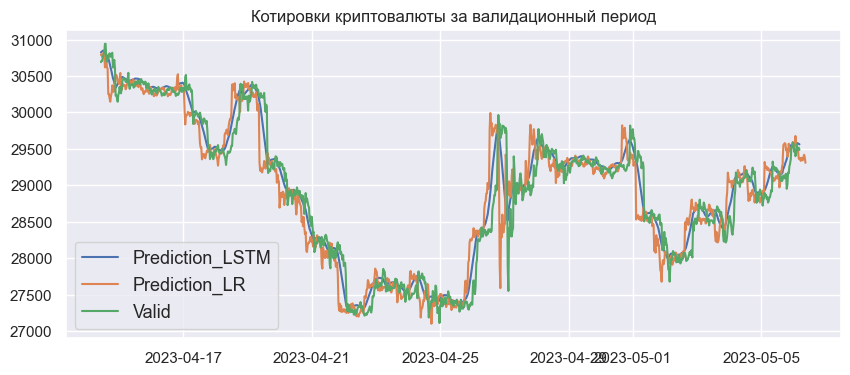

In [28]:
predict_lstm = pd.DataFrame(y_predict)
predict_lstm.index = predict_lr.index[:len(predict_lstm)]
valid_lstm = pd.DataFrame(ts_valid[:len(predict_lstm[0])])
valid_lstm.index = predict_lr.index[:len(predict_lstm)]
plt.figure(figsize=(10, 4))
plt.plot(predict_lstm[0],label='Prediction_LSTM')
plt.plot(predict_lr,label='Prediction_LR')
plt.plot(valid_lstm,label='Valid')
plt.legend(loc="best", fontsize=13)
plt.title('Котировки криптовалюты за валидационный период')
print('RMSE = ',np.sqrt(mean_squared_error(predict_lstm[0],valid_lstm[0])))
print('MAE = ',np.sqrt(mean_absolute_error(predict_lstm[0],valid_lstm[0])))

**Вывод: LSTM модель показало номинально хоть и более низкие показатели MAE, однако график LSTM показывает, что модель ближе идет к локальным экстремумам и перепадам. Так что не смотря на то, что LSTM модель сглаживает пики, она лучше предсказывает общий тренд**

*Посмотрим результат на тестовой выборке*

33/33 [==============================] - 0s 9ms/step
RMSE =  188.18554539777486
MAE =  11.388966730385604


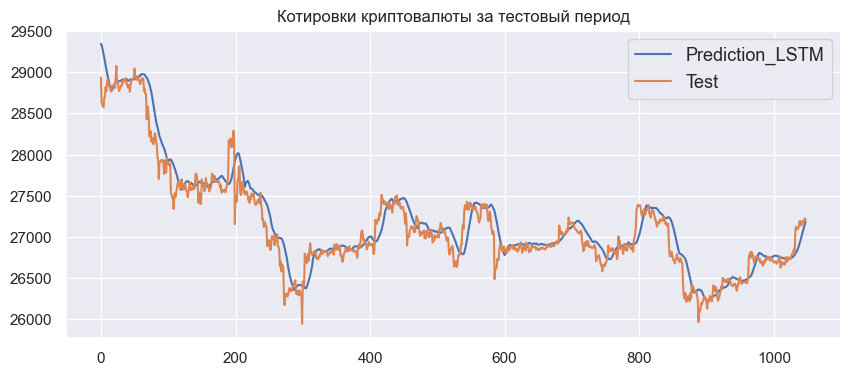

In [29]:
X_test, y_test = split_sequence(ts_test, n_steps_in, n_steps_out)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
test_predict = model.predict(X_test)
predict_lstm = pd.DataFrame(test_predict)
test_lstm = pd.DataFrame(y_test)
plt.figure(figsize=(10, 4))
plt.plot(predict_lstm[0],label='Prediction_LSTM')
plt.plot(test_lstm[0],label='Test')
plt.legend(loc="best", fontsize=13)
plt.title('Котировки криптовалюты за тестовый период')
print('RMSE = ',np.sqrt(mean_squared_error(predict_lstm[0],test_lstm[0])))
print('MAE = ',np.sqrt(mean_absolute_error(predict_lstm[0],test_lstm[0])))

**Из тестовой выборке видно, что модель сглаживает пики однако достаточно хорошо показывает общий тренд**

*Выведим предсказания за следующий час*

In [30]:
test_predict[-1]

array([27185.295, 27158.666], dtype=float32)

*Значение метрик равно* 

- RMSE =  296
- MAE =  15*